# FarmWise: Farmland Segmentation and Size Classification with U-Net

**Date**: April 14, 2025

This notebook implements a farm segmentation system using U-Net architecture to identify agricultural fields from satellite imagery, calculate their sizes, and classify them for targeted recommendations.

## Project Overview

**Goal**: Create a system that can:
1. Detect and segment farmlands from satellite imagery
2. Calculate the size/area of each identified farm
3. Classify farms by size (small, medium, large)
4. Enable a recommendation system based on farm size classification

**Approach**: U-Net architecture for semantic segmentation

## 1. Business Understanding

### 1.1 Problem Statement

Agricultural recommendations are most effective when tailored to the specific context of a farm, with farm size being a crucial factor. Large farms may benefit from different techniques, equipment, and crop selections compared to small ones. This project aims to automatically classify farms by size from satellite imagery to enable targeted recommendations.

### 1.2 Success Criteria

- **Technical Success**: Achieve high accuracy in farmland segmentation (IoU > 0.75)
- **Business Success**: Enable accurate size-based classification of farms for targeted recommendations

## 2. Data Acquisition and Understanding

### 2.1 Setup and Environment Preparation

In [1]:
# Check for Kaggle environment and set up dependencies for GPU acceleration
!pip install torch torchvision matplotlib numpy pillow scikit-learn scikit-image opencv-python roboflow tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.1 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.


In [2]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
from skimage import measure
from tqdm.notebook import tqdm
from roboflow import Roboflow

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability and set up CUDA device
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    
    # Use all available GPUs if there are multiple
    if num_gpus > 1:
        device = torch.device('cuda')
        print(f"Using {num_gpus} GPUs for data parallel training")
    else:
        device = torch.device('cuda:0')
        print("Using single GPU")
else:
    device = torch.device('cpu')
    print("No GPU available, using CPU. This will be slower.")

# Display CUDA version if available
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")

CUDA Available: True
Number of GPUs available: 1
GPU 0: Tesla P100-PCIE-16GB
Using single GPU
CUDA Version: 12.1
Current CUDA device: 0


### 2.2 Data Acquisition from Roboflow

In [3]:
# Initialize Roboflow and load dataset
# Note: You will need to provide your Roboflow API key
rf = Roboflow(api_key="HE9CEH5JxJ3U0vXrQTOy")  # Replace with your actual API key
project = rf.workspace("sid-mp92l").project("final-detectron-2")
dataset = project.version(1).download("yolov8")

# Print dataset path
print(f"Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Final-Detectron-2-1 in yolov8:: 100%|██████████| 15024/15024 [00:02<00:00, 6482.71it/s]


Dataset downloaded to: /kaggle/working/Final-Detectron-2-1


### 2.3 Dataset Exploration

Let's examine the structure of our dataset and visualize some sample images with their masks.

In [4]:
# Explore the dataset structure
def explore_directory(path, level=0):
    print('  ' * level + f"|-- {os.path.basename(path)}")
    if os.path.isdir(path):
        for item in os.listdir(path)[:10]:  # Limit to first 10 items
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                explore_directory(item_path, level + 1)
            else:
                print('  ' * (level + 1) + f"|-- {item}")
        if len(os.listdir(path)) > 10:
            print('  ' * (level + 1) + f"|-- ... ({len(os.listdir(path)) - 10} more items)")

print("Dataset Structure:")
explore_directory(dataset.location)

Dataset Structure:
|-- Final-Detectron-2-1
  |-- README.dataset.txt
  |-- README.roboflow.txt
  |-- data.yaml
  |-- valid
    |-- labels
      |-- 031310332013131_png_jpg.rf.8be5993605c52b2eab03f1f4e64096f6.txt
      |-- F_30002046_jpg.rf.4dab77c74d921ebdbfe770865746e846.txt
      |-- F_1945_jpg.rf.82d86a02771eaf154aef934d1beb37ac.txt
      |-- Image1254_jpg.rf.d952e3a98318ecd5f34ef7a7676ba40f.txt
      |-- F_30002762_jpg.rf.43ff1d614a0d355d2dfc9644163ac07c.txt
      |-- Image1304_jpg.rf.68c76f89553c6eb743392f5822248d46.txt
      |-- F_30001822_jpg.rf.0a89dd61511b0e2a0bec30c83e105333.txt
      |-- F_30002850_jpg.rf.4cffdffefc6899acc589e3b8188bdf4e.txt
      |-- 02130311211132_png_jpg.rf.41582675f7e5ee9445c6087d798bb8b5.txt
      |-- F_30001755_jpg.rf.e345d325122b331f09dbb1a51f34580d.txt
      |-- ... (708 more items)
    |-- images
      |-- F_1438_jpg.rf.c08fc957cc0cf3ffbe26236ebd638226.jpg
      |-- F_30001055_jpg.rf.fe95f09cf309f5204be20558afee8bcc.jpg
      |-- F_30002428_jpg.rf.68


--- Starting Random Sample Visualization (3 samples) ---


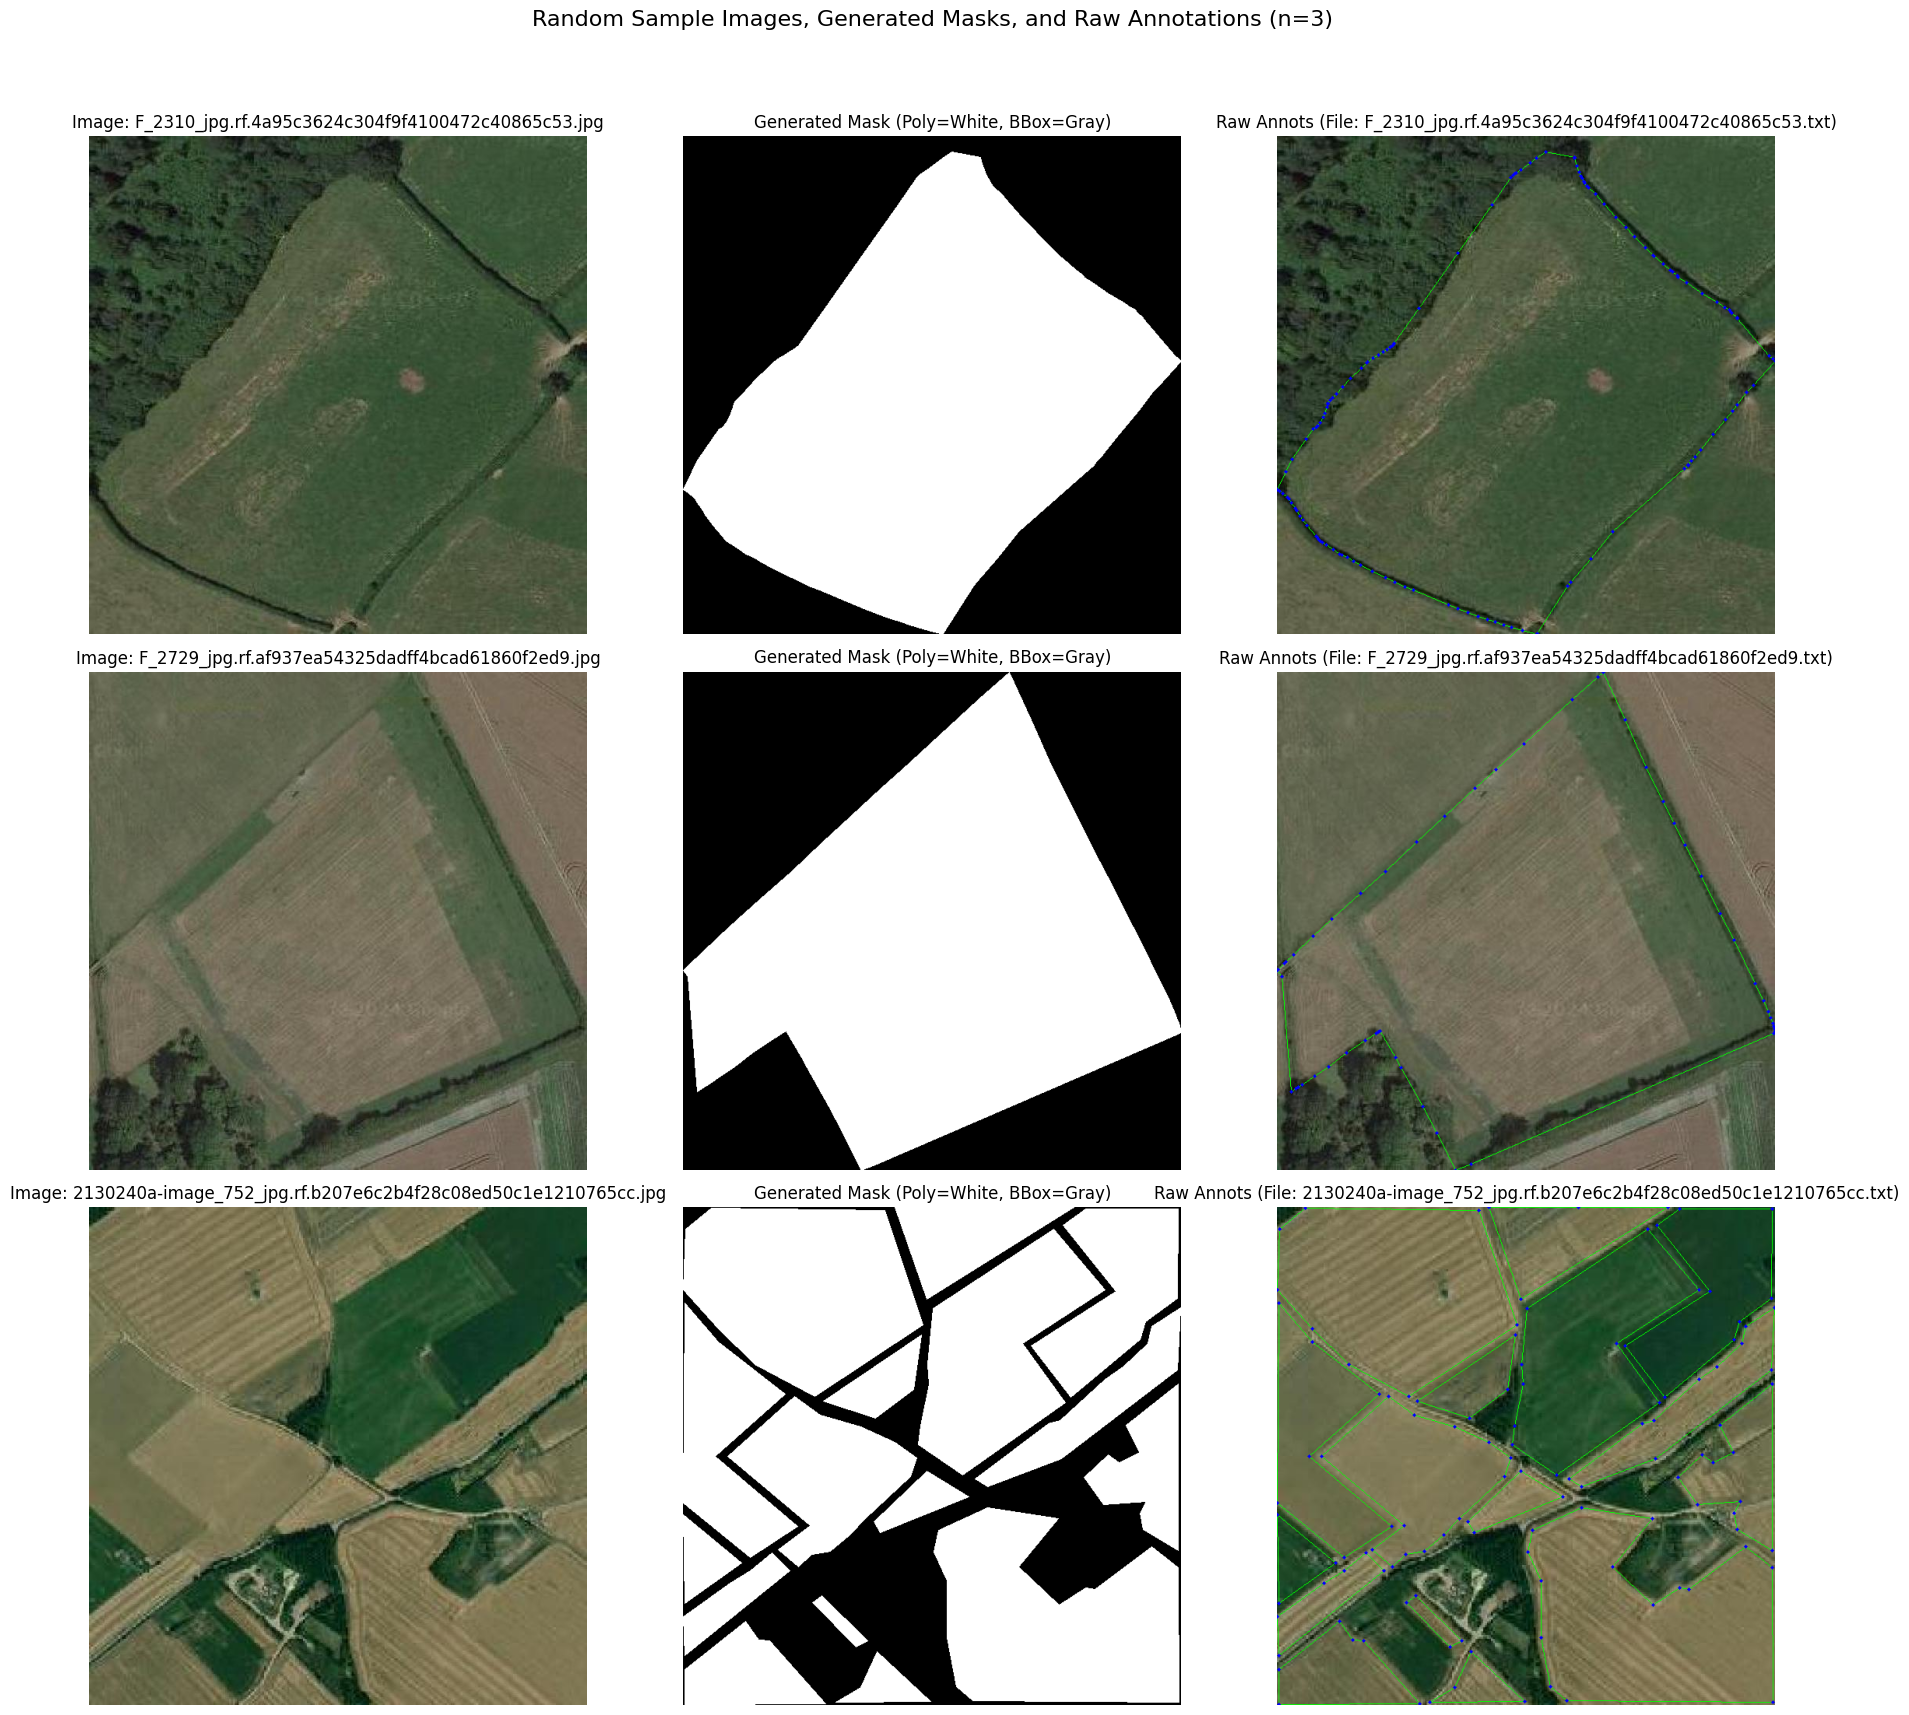

--- Finished Random Sample Visualization ---


In [5]:
# YAML needed for reading class information
import yaml
import random
import matplotlib.pyplot as plt

def visualize_samples(data_dir, num_samples=3):
    """Visualizes original images, generated masks from YOLO files, and raw annotations for a random sample."""

    print(f"\n--- Starting Random Sample Visualization ({num_samples} samples) ---")
    
    # Define image and mask directories
    train_img_dir = os.path.join(data_dir, 'train', 'images')
    train_mask_dir = os.path.join(data_dir, 'train', 'labels')
    
    # Basic path checks
    if not os.path.isdir(train_img_dir): 
        print(f"Error: Train image directory not found: {train_img_dir}")
        return
    if not os.path.isdir(train_mask_dir): 
        print(f"Error: Train mask directory not found: {train_mask_dir}")
        return

    # Get image files
    img_files_all = [f for f in os.listdir(train_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not img_files_all:
        print(f"No image files found in {train_img_dir}")
        return

    # Sample random images
    num_available = len(img_files_all)
    num_samples = min(num_samples, num_available)
    if num_samples == 0:
        print("No samples requested or available.")
        return
    img_files = random.sample(img_files_all, num_samples)

    # Load class names from data.yaml
    yaml_path = os.path.join(data_dir, 'data.yaml')
    class_names = ['Unknown']
    farm_class_id = None
    if os.path.exists(yaml_path):
        try:
            with open(yaml_path, 'r') as f: 
                data_yaml = yaml.safe_load(f)
            if 'names' in data_yaml:
                class_names = data_yaml['names']
                for i, name in enumerate(class_names):
                    if "farm" in name.lower():
                        farm_class_id = i
                        break
        except Exception as e: 
            print(f"Warning: Error reading class names from data.yaml: {e}")
    else: 
        print(f"Warning: data.yaml not found at {yaml_path}.")

    # Setup plot
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 6 * num_samples))
    if num_samples == 1:
        fig.suptitle("Random Sample Image, Generated Mask, and Raw Annotations", fontsize=16)
        axes = np.array([axes])
    else:
        plt.suptitle(f"Random Sample Images, Generated Masks, and Raw Annotations (n={num_samples})", fontsize=16)

    # Process each image
    for i, img_file in enumerate(img_files):
        ax_img, ax_mask, ax_raw = axes[i]
        img_path = os.path.join(train_img_dir, img_file)
        try: # Load image
            img = Image.open(img_path).convert("RGB")
            img_np = np.array(img)
            img_height, img_width = img_np.shape[:2]
        except Exception as e: # Handle image loading error
            print(f"Error loading image {img_file}: {e}")
            ax_img.set_title(f"Error loading {img_file}")
            ax_img.axis('off')
            ax_mask.set_title("Mask N/A")
            ax_mask.axis('off')
            ax_raw.set_title("Raw Annotations N/A")
            ax_raw.axis('off')
            continue

        # Prepare for drawing
        mask_file = os.path.splitext(img_file)[0] + '.txt'
        mask_path = os.path.join(train_mask_dir, mask_file)
        filled_mask = np.zeros((img_height, img_width), dtype=np.uint8)
        img_np_raw = img_np.copy()
        ax_img.imshow(img_np)
        ax_img.set_title(f"Image: {img_file}")
        ax_img.axis('off')
        ax_raw.set_title(f"Raw Annots (File: {mask_file})")
        ax_raw.axis('off')

        if os.path.exists(mask_path):
            try: # Read annotations
                with open(mask_path, 'r') as f: 
                    lines = f.readlines()
                for line in lines:
                    try: # Process single annotation line
                        parts = line.strip().split(' ')
                        if len(parts) < 5: 
                            continue
                        class_id = int(parts[0])
                        if farm_class_id is not None and class_id != farm_class_id: 
                            continue # Filter class
                        if len(parts) > 5 and len(parts) % 2 == 1: 
                            is_polygon=True # Polygon format: class x1 y1 x2 y2 ...
                        elif len(parts) == 5: 
                            is_polygon=False # Bbox format: class xc yc w h
                        else: 
                            continue # Skip ambiguous format
                        coords = parts[1:]
                        if is_polygon:
                             polygon_points_pixels = [(int(float(coords[j])*img_width), int(float(coords[j+1])*img_height)) for j in range(0, len(coords), 2)]
                             if len(polygon_points_pixels) >= 3:
                                 pts = np.array(polygon_points_pixels, np.int32).reshape((-1, 1, 2))
                                 cv2.fillPoly(filled_mask, [pts], 255) # Fill mask white
                                 outline_color_bgr=(0, 255, 0)
                                 vertex_color_bgr=(0, 0, 255)
                                 cv2.polylines(img_np_raw, [pts], True, outline_color_bgr, 1) # Draw raw outline
                                 for px, py in polygon_points_pixels: 
                                     cv2.circle(img_np_raw, (px, py), 2, vertex_color_bgr, -1) # Draw raw vertices
                        else: # Bbox
                            x_center, y_center, width, height = map(float, coords)
                            x1=max(0, int((x_center-width/2)*img_width))
                            y1=max(0, int((y_center-height/2)*img_height))
                            x2=min(img_width-1, int((x_center+width/2)*img_width))
                            y2=min(img_height-1, int((y_center+height/2)*img_height))
                            cv2.rectangle(filled_mask, (x1, y1), (x2, y2), 128, -1) # Fill mask gray for bbox
                            bbox_color_bgr = (255, 0, 0)
                            cv2.rectangle(img_np_raw, (x1, y1), (x2, y2), bbox_color_bgr, 1) # Draw raw bbox outline
                    except (ValueError, IndexError, Exception): 
                        pass # Silently ignore line processing errors
            except Exception: 
                ax_mask.set_title("Error reading mask file")
                ax_raw.set_title("Error reading mask file") # Handle file read error
        else: 
            ax_mask.set_title("Mask file missing")
            ax_raw.set_title("Annotation file missing") # Handle missing mask file

        # Display final results for the row
        ax_mask.imshow(filled_mask, cmap='gray', vmin=0, vmax=255)
        ax_mask.set_title("Generated Mask (Poly=White, BBox=Gray)")
        ax_mask.axis('off')
        ax_raw.imshow(img_np_raw)
        ax_raw.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print("--- Finished Random Sample Visualization ---")


# Run the visualization with 3 samples
if 'dataset' in locals() and hasattr(dataset, 'location'):
    try:
        # Set to 3 to show 3 random samples
        num_visual_samples = 3
        visualize_samples(dataset.location, num_samples=num_visual_samples)
    except Exception as e:
        import traceback
        traceback.print_exc()
        print(f"An unexpected error occurred during visualization: {e}")
else:
    print("\nError: Dataset is not properly loaded. Cannot run visualization.")

### 2.4 Data Preparation

We need to convert YOLOv8 format annotations to segmentation masks for U-Net training.

In [6]:
# === Section 2.3: Dataset Exploration and Definition ===
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import cv2
import yaml # Make sure yaml is imported
import torch.nn.functional as F # Ensure F is imported for interpolate

# Define paths after loading the dataset
# Ensure the 'dataset' variable is available from the download cell
if 'dataset' in locals() and hasattr(dataset, 'location'):
    dataset_base_dir = dataset.location # For finding data.yaml and overall root
    train_img_dir = os.path.join(dataset_base_dir, 'train', 'images')
    train_mask_dir = os.path.join(dataset_base_dir, 'train', 'labels')
    val_img_dir = os.path.join(dataset_base_dir, 'valid', 'images')
    val_mask_dir = os.path.join(dataset_base_dir, 'valid', 'labels')
    print(f"Dataset paths set using location: {dataset.location}")
else:
    # Fallback or error if dataset location is not defined
    print("ERROR: 'dataset' variable or 'dataset.location' not found.")
    print("Please run the Roboflow download cell first.")
    # Define dummy paths to avoid crashing subsequent cells, but processing will fail
    dataset_base_dir = "."
    train_img_dir = os.path.join(dataset_base_dir, 'train', 'images')
    train_mask_dir = os.path.join(dataset_base_dir, 'train', 'labels')
    val_img_dir = os.path.join(dataset_base_dir, 'valid', 'images')
    val_mask_dir = os.path.join(dataset_base_dir, 'valid', 'labels')


# --- Custom Dataset Class (Less Verbose) ---
class FarmlandDataset(Dataset):
    """
    PyTorch Dataset for loading satellite images and generating segmentation masks
    from YOLOv8 polygon annotation files. Less verbose version.
    """
    def __init__(self, img_dir, mask_dir, dataset_root_dir, transform=None, farm_class_name="farm", img_size=256):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_size = img_size
        self.farm_class_name = farm_class_name

        # Filter for valid image files only
        try:
            self.img_files = sorted([
                f for f in os.listdir(img_dir)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            if not self.img_files:
                 print(f"Warning: No image files found in {self.img_dir}") # Keep important warning
        except FileNotFoundError:
             print(f"Error: Image directory not found: {self.img_dir}. Dataset will be empty.") # Keep critical error
             self.img_files = []

        self.class_names = ['Unknown']
        self.farm_class_id = None
        self._load_class_info(dataset_root_dir)


    def _load_class_info(self, dataset_root_dir):
        """Loads class names and identifies the farm class ID from data.yaml."""
        yaml_path = os.path.join(dataset_root_dir, 'data.yaml')
        if os.path.exists(yaml_path):
            try:
                with open(yaml_path, 'r') as f:
                    data_yaml = yaml.safe_load(f)
                    if 'names' in data_yaml:
                        self.class_names = data_yaml['names']
                        for i, name in enumerate(self.class_names):
                            if self.farm_class_name.lower() in name.lower():
                                self.farm_class_id = i; break
                        if self.farm_class_id is None:
                            print(f"Warning: Target class name '{self.farm_class_name}' not found in data.yaml names: {self.class_names}") # Keep warning
                    else:
                        print(f"Warning: 'names' key not found in {yaml_path}") # Keep warning
            except ImportError:
                 print("Warning: PyYAML not installed. Cannot read class names from data.yaml.") # Keep warning
            except Exception as e:
                print(f"Warning: Error reading class names from data.yaml: {e}") # Keep warning
        else:
             print(f"Warning: data.yaml not found at {yaml_path}. Cannot determine farm class ID automatically.") # Keep warning

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        if idx >= len(self.img_files):
             raise IndexError("Index out of bounds")

        img_filename = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)

        try:
            image = Image.open(img_path).convert("RGB")
            original_width, original_height = image.size
        except Exception:
            # Return dummy tensors silently if image loading fails
            dummy_image = torch.zeros((3, self.img_size, self.img_size))
            dummy_mask = torch.zeros((1, self.img_size, self.img_size))
            return dummy_image, dummy_mask

        mask_file = os.path.splitext(img_filename)[0] + '.txt'
        mask_path = os.path.join(self.mask_dir, mask_file)
        mask = np.zeros((original_height, original_width), dtype=np.float32)

        if os.path.exists(mask_path):
            try:
                with open(mask_path, 'r') as f: lines = f.readlines()
                for line in lines:
                    try:
                        parts = line.strip().split(' ')
                        if len(parts) < 5: continue
                        class_id = int(parts[0])
                        if self.farm_class_id is not None and class_id != self.farm_class_id: continue
                        if len(parts) > 5 and len(parts) % 2 == 1: # Polygon: class x1 y1 x2 y2 ...
                            polygon_points_normalized = []
                            for j in range(1, len(parts), 2):
                                 if j + 1 < len(parts):
                                     x_norm = float(parts[j]); y_norm = float(parts[j+1])
                                     polygon_points_normalized.append((x_norm, y_norm))
                            polygon_points_pixels = [(int(x*original_width), int(y*original_height)) for x,y in polygon_points_normalized]
                            if len(polygon_points_pixels) >= 3:
                                pts = np.array(polygon_points_pixels, np.int32).reshape((-1, 1, 2))
                                cv2.fillPoly(mask, [pts], 1.0)
                        # Ignore bounding boxes (len(parts) == 5) for mask generation
                    except (ValueError, IndexError): continue # Silently ignore errors in single line processing
            except Exception: pass # Silently ignore file reading errors

        # --- Transformations ---
        if not self.transform:
             resizer = transforms.Resize((self.img_size, self.img_size), interpolation=transforms.InterpolationMode.BILINEAR)
             to_tensor = transforms.ToTensor()
             image_resized = resizer(image)
             image_tensor = to_tensor(image_resized)
             mask_resized = cv2.resize(mask, (self.img_size, self.img_size), interpolation=cv2.INTER_NEAREST)
             mask_tensor = torch.from_numpy(mask_resized).float().unsqueeze(0)
        else:
             image_tensor = self.transform(image)
             target_h, target_w = image_tensor.shape[-2:]
             mask_resized = cv2.resize(mask, (target_w, target_h), interpolation=cv2.INTER_NEAREST)
             mask_tensor = torch.from_numpy(mask_resized).float().unsqueeze(0)

        if image_tensor.shape[-2:] != mask_tensor.shape[-2:]:
              try: # Attempt silent correction
                  mask_tensor = F.interpolate(mask_tensor.unsqueeze(0), size=image_tensor.shape[-2:], mode='nearest').squeeze(0)
              except Exception: # Return dummy on correction failure
                   dummy_image = torch.zeros((3, self.img_size, self.img_size)); dummy_mask = torch.zeros((1, self.img_size, self.img_size))
                   return dummy_image, dummy_mask

        mask_tensor = torch.clamp(mask_tensor, 0.0, 1.0)
        return image_tensor, mask_tensor

Dataset paths set using location: /kaggle/working/Final-Detectron-2-1


In [7]:
# Set up augmented data transformations to prevent overfitting
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flips
    transforms.RandomVerticalFlip(p=0.5),    # Random vertical flips
    transforms.RandomRotation(10),           # Random rotations up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Keep validation transform simple
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets with separate transforms
train_dataset = FarmlandDataset(train_img_dir, train_mask_dir, dataset_base_dir, transform=train_transform)
val_dataset = FarmlandDataset(val_img_dir, val_mask_dir, dataset_base_dir, transform=val_transform)

# Optimize batch size based on available GPUs and model complexity
if torch.cuda.device_count() > 1:
    batch_size = 24  # Increased batch size for multiple GPUs
else:
    batch_size = 8   # Default batch size for single GPU

# Determine optimal number of workers for data loading
num_workers = min(os.cpu_count(), 16) if os.cpu_count() else 4

# Configure DataLoader with more aggressive prefetching and optimized memory usage
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers,        # More workers for faster data loading
    pin_memory=True,                # Use pinned memory for faster CPU->GPU transfer
    prefetch_factor=4,              # Prefetch more batches
    persistent_workers=True,        # Keep worker processes alive between iterations
    drop_last=True                  # Drop last incomplete batch for better performance
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers,
    pin_memory=True,
    prefetch_factor=4,
    persistent_workers=True
)

# Adjust CUDA settings for optimal performance
torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner to find the best algorithm
torch.backends.cudnn.deterministic = False
torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on Ampere GPUs
torch.backends.cudnn.allow_tf32 = True        # Allow TF32 on Ampere GPUs

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Using batch size: {batch_size} with {torch.cuda.device_count()} GPUs")
print(f"DataLoader configured with {num_workers} worker processes")
print(f"Data augmentation enabled for training to prevent overfitting")
print(f"CUDA optimizations enabled: benchmark={torch.backends.cudnn.benchmark}, TF32={torch.backends.cuda.matmul.allow_tf32}")

Train dataset size: 5958
Validation dataset size: 718
Using batch size: 8 with 1 GPUs
DataLoader configured with 4 worker processes
Data augmentation enabled for training to prevent overfitting
CUDA optimizations enabled: benchmark=True, TF32=True


## 3. Modeling

### 3.1 U-Net Architecture

We'll implement an efficient U-Net architecture with GroupNorm for better performance.

In [8]:
# Efficient U-Net implementation with memory optimization
class EfficientUNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super(EfficientUNet, self).__init__()
        
        # Use GroupNorm instead of BatchNorm for better performance with large batch sizes
        # and more stability across different batch sizes
        
        # Encoder (downsampling)
        self.enc1 = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=64),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=16, num_channels=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=16, num_channels=128),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(2)
        
        self.enc4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=512),
            nn.ReLU(inplace=True)
        )
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=1024),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=512),
            nn.ReLU(inplace=True)
        )
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=32, num_channels=256),
            nn.ReLU(inplace=True)
        )
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=16, num_channels=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=16, num_channels=128),
            nn.ReLU(inplace=True)
        )
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=64),
            nn.ReLU(inplace=True)
        )
        
        # Final output layer
        self.outconv = nn.Conv2d(64, n_classes, kernel_size=1)
        
        # Initialize weights properly for faster convergence
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.GroupNorm):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)
        
        # Bottleneck
        b = self.bottleneck(p4)
        
        # Decoder with skip connections
        u4 = self.upconv4(b)
        u4 = torch.cat([u4, e4], dim=1)  # Skip connection
        d4 = self.dec4(u4)
        
        u3 = self.upconv3(d4)
        u3 = torch.cat([u3, e3], dim=1)  # Skip connection
        d3 = self.dec3(u3)
        
        u2 = self.upconv2(d3)
        u2 = torch.cat([u2, e2], dim=1)  # Skip connection
        d2 = self.dec2(u2)
        
        u1 = self.upconv1(d2)
        u1 = torch.cat([u1, e1], dim=1)  # Skip connection
        d1 = self.dec1(u1)
        
        # Final output - return logits directly (no sigmoid)
        # This is crucial for compatibility with BCEWithLogitsLoss and AMP
        out = self.outconv(d1)
        return out  # Ensure no sigmoid activation here

In [9]:
# Initialize the model and optimizer
model = EfficientUNet(n_channels=3, n_classes=1)

# Move model to GPU if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs for parallel training")
    model = nn.DataParallel(model)

model = model.to(device)

# Define loss function and optimizer
# Ensure BCEWithLogitsLoss is used, as it's safe for AMP and expects raw logits from the model
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)  # AdamW with weight decay to reduce overfitting

# Print model architecture summary
print(f"Model Architecture: EfficientUNet with GroupNorm")
print(f"Model Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")
print(f"Optimizer: AdamW with learning rate 0.001 and weight decay 1e-4")
print(f"Loss Function: Binary Cross Entropy Loss with Logits (BCEWithLogitsLoss)")
print(f"Device: {device}")

Model Architecture: EfficientUNet with GroupNorm
Model Parameters: 31,043,521 trainable parameters
Optimizer: AdamW with learning rate 0.001 and weight decay 1e-4
Loss Function: Binary Cross Entropy Loss with Logits (BCEWithLogitsLoss)
Device: cuda:0


### 3.2 Training Functions

We'll define optimized functions for training, validation, and model evaluation with IoU (Intersection over Union) metric.

In [10]:
# Define training and validation functions
def train_epoch(model, dataloader, criterion, optimizer, device, amp_scaler=None):
    """Trains the model for one epoch with optional mixed precision"""
    model.train()
    running_loss = 0.0
    processed_samples = 0
    
    # Use tqdm for progress tracking
    for images, masks in tqdm(dataloader, desc="Training"):
        images = images.to(device, non_blocking=True)  # Use non_blocking for async transfer
        masks = masks.to(device, non_blocking=True)
        batch_size = images.size(0)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Mixed precision training
        if amp_scaler is not None:
            with torch.amp.autocast(device_type='cuda'):
                # Forward pass
                outputs = model(images)
                # Calculate loss using BCEWithLogitsLoss (expects logits)
                loss = criterion(outputs, masks)
            
            # Backward pass with gradient scaling
            amp_scaler.scale(loss).backward()
            amp_scaler.step(optimizer)
            amp_scaler.update()
        else:
            # Standard training
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * batch_size
        processed_samples += batch_size
    
    epoch_loss = running_loss / processed_samples
    return epoch_loss

def validate_epoch(model, dataloader, criterion, device):
    """Validates the model and calculates validation loss"""
    model.eval()
    running_loss = 0.0
    processed_samples = 0
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation"):
            images = images.to(device)
            masks = masks.to(device)
            batch_size = images.size(0)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            running_loss += loss.item() * batch_size
            processed_samples += batch_size
    
    epoch_loss = running_loss / processed_samples
    return epoch_loss

def calculate_iou(pred, target, threshold=0.5):
    """Calculates Intersection over Union between prediction and target mask"""
    # Apply sigmoid to logits before thresholding, as model outputs logits
    pred_sigmoid = torch.sigmoid(pred)
    pred_binary = (pred_sigmoid > threshold).float()
    intersection = (pred_binary * target).sum()
    union = pred_binary.sum() + target.sum() - intersection
    
    iou = (intersection + 1e-8) / (union + 1e-8)  # Small epsilon to avoid division by zero
    return iou.item()

def evaluate_model(model, dataloader, device, threshold=0.5):
    """Evaluates model performance using IoU metric"""
    model.eval()
    iou_scores = []
    total_samples = 0
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating IoU"):
            images = images.to(device)
            masks = masks.to(device)
            batch_size = images.size(0)
            
            # Forward pass
            outputs = model(images)
            
            # Calculate IoU for each image in batch
            for i in range(batch_size):
                iou = calculate_iou(outputs[i], masks[i], threshold)
                iou_scores.append(iou)
            
            total_samples += batch_size
    
    mean_iou = sum(iou_scores) / len(iou_scores) if iou_scores else 0
    return mean_iou

### 3.3 Training Loop

Now we'll run the training process with clear metrics reporting and visualization.

In [11]:
# Import dependencies for mixed precision training
import torch.cuda.amp as amp

# Set up training parameters
num_epochs = 30 # Adjust based on dataset size and complexity
best_val_loss = float('inf')
best_model_path = 'best_unet_model.pth'
patience = 10 # Early stopping patience
no_improve_epochs = 0

# Set up mixed precision training for faster performance if CUDA is available
scaler = None
if torch.cuda.is_available():
    scaler = amp.GradScaler()
    print("Using mixed precision training for faster performance")
else:
    print("CUDA not available, using standard precision (slower)")

# Set up learning rate scheduler to reduce LR when training plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Initialize lists to store metrics for plotting
train_losses = []
val_losses = []
val_ious = []
learning_rates = []

# Print training configuration
print(f"Training Configuration:")
print(f"- Epochs: {num_epochs} (early stopping patience: {patience})")
print(f"- Batch size: {batch_size}")
print(f"- Learning rate: {optimizer.param_groups[0]['lr']} with ReduceLROnPlateau")
print(f"- Mixed precision: {'Enabled' if scaler else 'Disabled'}")
print(f"- Best model will be saved to: {best_model_path}")

# Training loop with clean, organized output
print("\nStarting Training...")
print("-" * 80)
print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^12} | {'Val IoU':^10} | {'LR':^9} | {'Time (min)':^12} | {'Status':^20}")
print("-" * 80)

import time
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device, amp_scaler=scaler)
    train_losses.append(train_loss)
    
    # Validate
    val_loss = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Calculate IoU for monitoring performance
    val_iou = evaluate_model(model, val_loader, device)
    val_ious.append(val_iou)
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    # Time tracking
    epoch_time = (time.time() - epoch_start) / 60  # convert to minutes
    total_time = (time.time() - start_time) / 60
    
    # Check for improvement
    if val_loss < best_val_loss:
        improvement = best_val_loss - val_loss
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        status = f"Improved ({improvement:.4f})"
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        status = f"No improvement ({no_improve_epochs}/{patience})"
    
    # Print epoch summary
    print(f"{epoch+1:^7} | {train_loss:^12.4f} | {val_loss:^12.4f} | {val_iou:^10.4f} | {current_lr:^9.6f} | {epoch_time:^12.2f} | {status:^20}")
    
    # Early stopping check
    if no_improve_epochs >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs without improvement.")
        break

# Print training summary
print("-" * 80)
print(f"Training completed in {total_time:.2f} minutes")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best model saved to: {best_model_path}")
print("-" * 80)

Using mixed precision training for faster performance
Training Configuration:
- Epochs: 30 (early stopping patience: 10)
- Batch size: 8
- Learning rate: 0.001 with ReduceLROnPlateau
- Mixed precision: Enabled
- Best model will be saved to: best_unet_model.pth

Starting Training...
--------------------------------------------------------------------------------
 Epoch  |  Train Loss  |   Val Loss   |  Val IoU   |    LR     |  Time (min)  |        Status       
--------------------------------------------------------------------------------


`torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

   1    |    0.5953    |    0.4972    |   0.7069   | 0.001000  |     3.82     |    Improved (inf)   


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

   2    |    0.5407    |    0.4845    |   0.7147   | 0.001000  |     3.34     |  Improved (0.0127)  


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

   3    |    0.5292    |    0.4671    |   0.7337   | 0.001000  |     3.34     |  Improved (0.0173)  


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

   4    |    0.5198    |    0.4712    |   0.7306   | 0.001000  |     3.34     | No improvement (1/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

   5    |    0.5127    |    0.4510    |   0.7416   | 0.001000  |     3.34     |  Improved (0.0161)  


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

   6    |    0.5078    |    0.4770    |   0.7307   | 0.001000  |     3.34     | No improvement (1/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

   7    |    0.5026    |    0.4606    |   0.7215   | 0.001000  |     3.34     | No improvement (2/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

   8    |    0.4992    |    0.4484    |   0.7438   | 0.001000  |     3.35     |  Improved (0.0026)  


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

   9    |    0.4953    |    0.4550    |   0.7426   | 0.001000  |     3.34     | No improvement (1/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  10    |    0.4930    |    0.4363    |   0.7372   | 0.001000  |     3.34     |  Improved (0.0121)  


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  11    |    0.4902    |    0.4317    |   0.7582   | 0.001000  |     3.34     |  Improved (0.0046)  


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  12    |    0.4878    |    0.4441    |   0.7476   | 0.001000  |     3.34     | No improvement (1/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  13    |    0.4857    |    0.4321    |   0.7526   | 0.001000  |     3.34     | No improvement (2/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  14    |    0.4818    |    0.4263    |   0.7508   | 0.001000  |     3.34     |  Improved (0.0054)  


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  15    |    0.4803    |    0.4033    |   0.7656   | 0.001000  |     3.34     |  Improved (0.0231)  


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  16    |    0.4803    |    0.4315    |   0.7456   | 0.001000  |     3.34     | No improvement (1/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  17    |    0.4737    |    0.4256    |   0.7553   | 0.001000  |     3.34     | No improvement (2/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  18    |    0.4730    |    0.4201    |   0.7494   | 0.001000  |     3.34     | No improvement (3/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  19    |    0.4704    |    0.4133    |   0.7609   | 0.001000  |     3.34     | No improvement (4/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  20    |    0.4623    |    0.4052    |   0.7510   | 0.000500  |     3.34     | No improvement (5/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  21    |    0.4606    |    0.4096    |   0.7456   | 0.000500  |     3.34     | No improvement (6/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  22    |    0.4590    |    0.3969    |   0.7526   | 0.000500  |     3.34     |  Improved (0.0063)  


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  23    |    0.4577    |    0.4020    |   0.7587   | 0.000500  |     3.34     | No improvement (1/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  24    |    0.4563    |    0.3903    |   0.7620   | 0.000500  |     3.34     |  Improved (0.0066)  


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  25    |    0.4546    |    0.4048    |   0.7444   | 0.000500  |     3.34     | No improvement (1/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  26    |    0.4528    |    0.4019    |   0.7523   | 0.000500  |     3.34     | No improvement (2/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  27    |    0.4526    |    0.3949    |   0.7640   | 0.000500  |     3.34     | No improvement (3/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  28    |    0.4507    |    0.4005    |   0.7572   | 0.000500  |     3.34     | No improvement (4/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  29    |    0.4457    |    0.3903    |   0.7553   | 0.000250  |     3.34     | No improvement (5/10)


Training:   0%|          | 0/744 [00:00<?, ?it/s]

Validation:   0%|          | 0/90 [00:00<?, ?it/s]

Evaluating IoU:   0%|          | 0/90 [00:00<?, ?it/s]

  30    |    0.4436    |    0.3878    |   0.7668   | 0.000250  |     3.34     |  Improved (0.0025)  
--------------------------------------------------------------------------------
Training completed in 100.78 minutes
Best validation loss: 0.3878
Best model saved to: best_unet_model.pth
--------------------------------------------------------------------------------


### 3.4 Visualize Training Results

Let's visualize our training progress to better understand model performance.

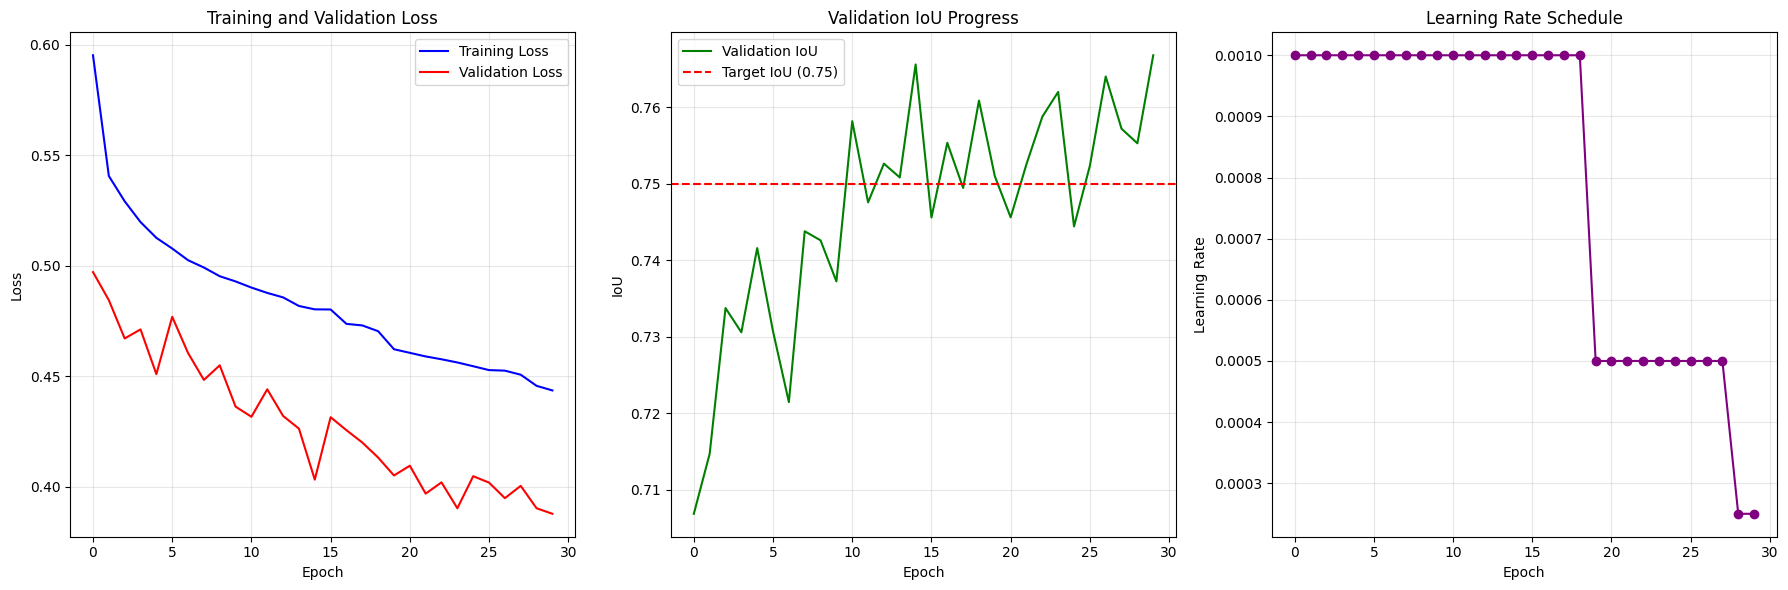

Training Summary:
- Total epochs trained: 30
- Best validation IoU: 0.7668 (epoch 30)
- Best validation loss: 0.3878 (epoch 30)
- Final training loss: 0.4436
- Final validation loss: 0.3878
- Final validation IoU: 0.7668


In [12]:
# Plot training metrics
plt.figure(figsize=(18, 6))

# Plot loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot IoU progress
plt.subplot(1, 3, 2)
plt.plot(val_ious, 'g-', label='Validation IoU')
plt.axhline(y=0.75, color='r', linestyle='--', label='Target IoU (0.75)')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Validation IoU Progress')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot learning rate changes
plt.subplot(1, 3, 3)
plt.plot(learning_rates, 'o-', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final performance summary
final_epoch = len(train_losses)
best_iou_idx = val_ious.index(max(val_ious))
best_loss_idx = val_losses.index(min(val_losses))

print(f"Training Summary:")
print(f"- Total epochs trained: {final_epoch}")
print(f"- Best validation IoU: {max(val_ious):.4f} (epoch {best_iou_idx+1})")
print(f"- Best validation loss: {min(val_losses):.4f} (epoch {best_loss_idx+1})")
print(f"- Final training loss: {train_losses[-1]:.4f}")
print(f"- Final validation loss: {val_losses[-1]:.4f}")
print(f"- Final validation IoU: {val_ious[-1]:.4f}")

## 4. Model Evaluation and Visualization

Let's load our best model and evaluate its performance on test images.

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Loaded best model from best_unet_model.pth
Visualizing model predictions on validation data...


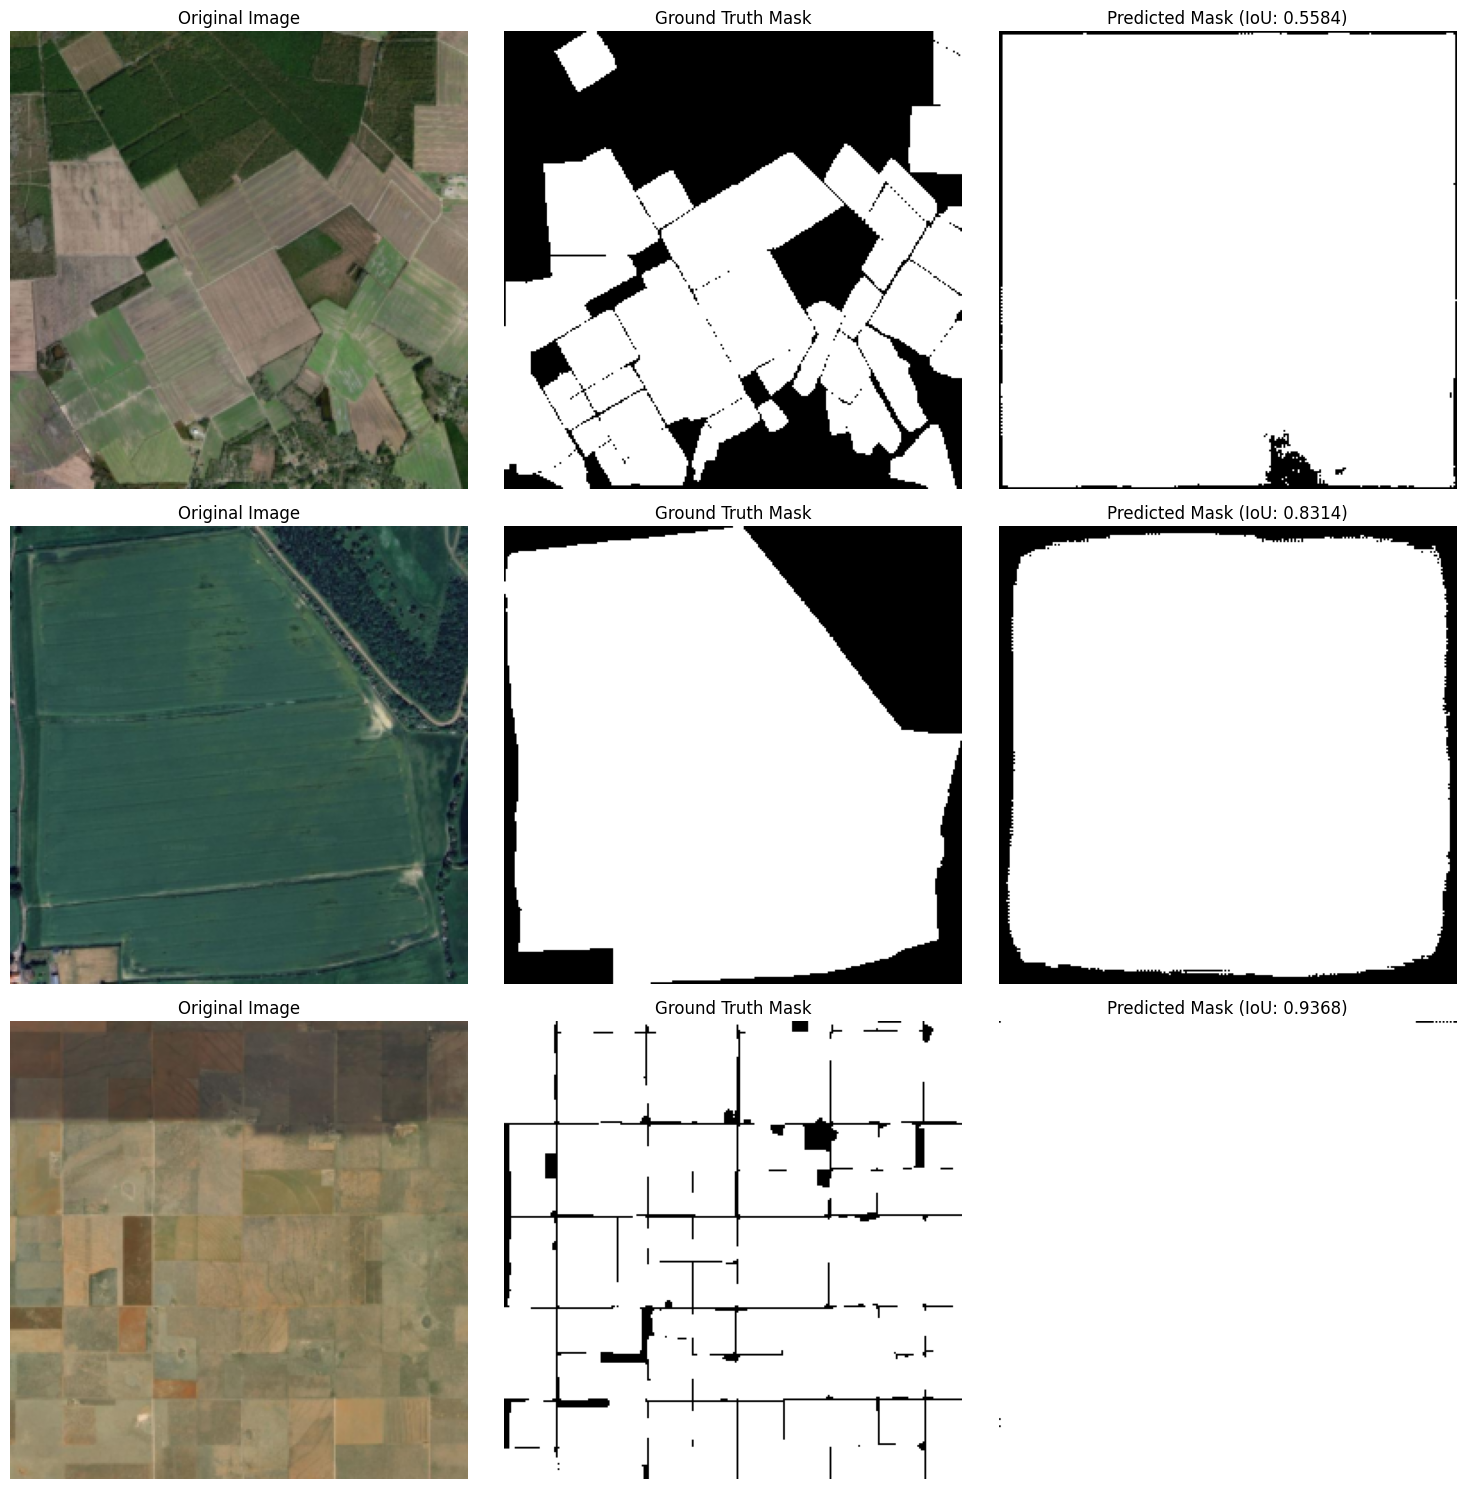


Visualizing segmentation overlay and error analysis...


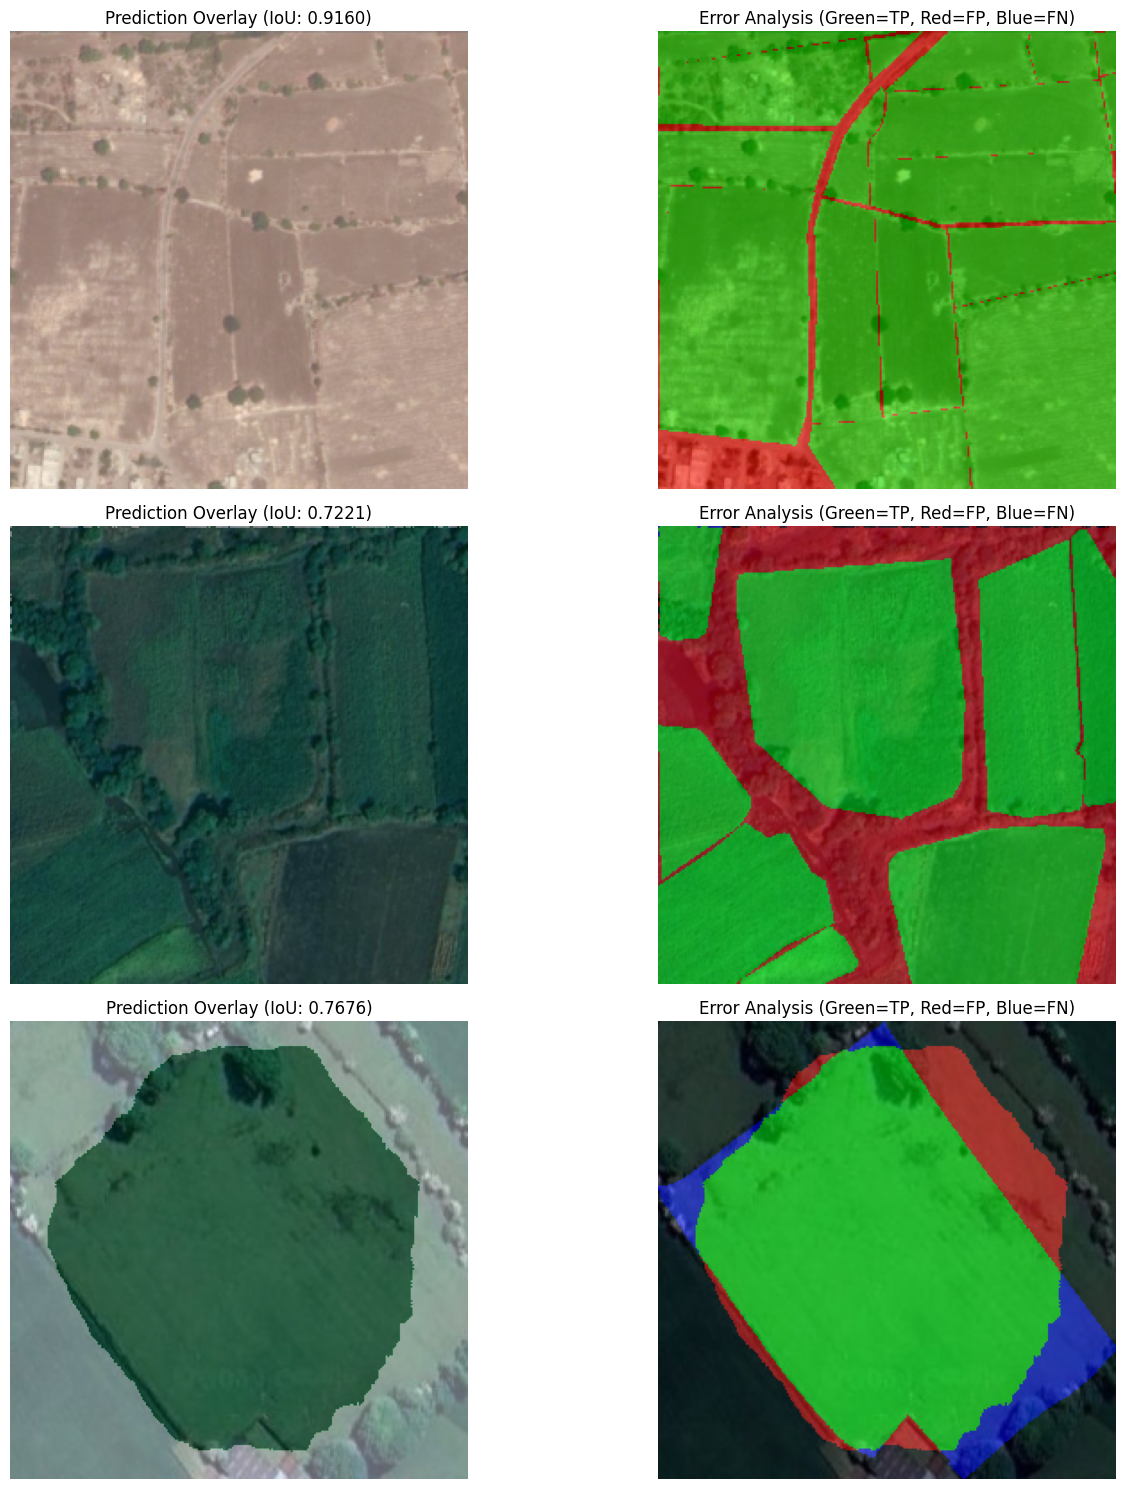

In [13]:
# Load the best model for evaluation
if os.path.exists(best_model_path):
    # Load saved weights into model
    model.load_state_dict(torch.load(best_model_path))
    print(f"Loaded best model from {best_model_path}")
else:
    print("Using current model weights (best model not found)")

# Set model to evaluation mode
model.eval()

# Function to visualize model predictions
def visualize_predictions(model, dataset, device, num_samples=3):
    """Visualize model predictions on random test samples"""
    # Get loader for single images
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Get random indices
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, idx in enumerate(indices):
        # Get a sample
        image_tensor, mask_tensor = dataset[idx]
        image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
        mask_tensor = mask_tensor.cpu().numpy().squeeze()  # Remove channel dimension
        
        # Get model prediction
        with torch.no_grad():
            output = model(image_tensor)
            # Apply sigmoid to convert logits to probabilities
            output_sigmoid = torch.sigmoid(output)
            predicted_mask = output_sigmoid.squeeze().cpu().numpy()
        
        # Get original image (unnormalize)
        image = image_tensor.squeeze().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))  # Change from CxHxW to HxWxC
        # Unnormalize image for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        # Create binary predicted mask
        predicted_binary = (predicted_mask > 0.5).astype(np.uint8)
        
        # Calculate IoU between prediction and ground truth
        intersection = np.logical_and(predicted_binary, mask_tensor > 0.5).sum()
        union = np.logical_or(predicted_binary, mask_tensor > 0.5).sum()
        iou = intersection / union if union > 0 else 0
        
        # Visualization - original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f"Original Image")
        plt.axis('off')
        
        # Visualization - ground truth mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(mask_tensor, cmap='gray')
        plt.title(f"Ground Truth Mask")
        plt.axis('off')
        
        # Visualization - predicted mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(predicted_binary, cmap='gray')
        plt.title(f"Predicted Mask (IoU: {iou:.4f})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return None

# Function to create overlay visualization
def visualize_segmentation_overlay(model, dataset, device, num_samples=3):
    """Create an overlay visualization of segmentation on the original image"""
    # Get loader for single images
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    
    # Get random indices
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)
    
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, idx in enumerate(indices):
        # Get a sample
        image_tensor, mask_tensor = dataset[idx]
        image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
        mask_tensor = mask_tensor.cpu().numpy().squeeze()  # Remove channel dimension
        
        # Get model prediction
        with torch.no_grad():
            output = model(image_tensor)
            # Apply sigmoid to logits
            output_sigmoid = torch.sigmoid(output)
            predicted_mask = output_sigmoid.squeeze().cpu().numpy()
        
        # Get original image (unnormalize)
        image = image_tensor.squeeze().cpu().numpy()
        image = np.transpose(image, (1, 2, 0))  # Change from CxHxW to HxWxC
        # Unnormalize image for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        
        # Create binary predicted mask
        predicted_binary = (predicted_mask > 0.5).astype(np.uint8)
        
        # Calculate IoU between prediction and ground truth
        intersection = np.logical_and(predicted_binary, mask_tensor > 0.5).sum()
        union = np.logical_or(predicted_binary, mask_tensor > 0.5).sum()
        iou = intersection / union if union > 0 else 0
        
        # Create overlay image
        plt.subplot(num_samples, 2, i*2 + 1)
        plt.imshow(image)
        plt.imshow(predicted_binary, alpha=0.4, cmap='Greens')
        plt.title(f"Prediction Overlay (IoU: {iou:.4f})")
        plt.axis('off')
        
        # Show side-by-side difference visualization
        plt.subplot(num_samples, 2, i*2 + 2)
        # Create RGB overlay: Green = correct prediction, Red = false positive, Blue = false negative
        overlay = np.zeros((predicted_binary.shape[0], predicted_binary.shape[1], 3))
        # True positive (where prediction and ground truth agree) - Green
        overlay[np.logical_and(predicted_binary, mask_tensor > 0.5), 1] = 1.0
        # False positive (prediction positive but ground truth negative) - Red
        overlay[np.logical_and(predicted_binary, mask_tensor <= 0.5), 0] = 1.0
        # False negative (prediction negative but ground truth positive) - Blue
        overlay[np.logical_and(np.logical_not(predicted_binary), mask_tensor > 0.5), 2] = 1.0
        
        plt.imshow(image)
        plt.imshow(overlay, alpha=0.5)
        plt.title(f"Error Analysis (Green=TP, Red=FP, Blue=FN)")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return None

# Visualize predictions on validation set
print("Visualizing model predictions on validation data...")
visualize_predictions(model, val_dataset, device, num_samples=3)

# Visualize overlay on validation set
print("\nVisualizing segmentation overlay and error analysis...")
visualize_segmentation_overlay(model, val_dataset, device, num_samples=3)

### 4.1 Quantitative Model Evaluation

Let's evaluate the model's performance on the validation set with various metrics.

Evaluating Metrics:   0%|          | 0/90 [00:00<?, ?it/s]

Model Performance Metrics:
   Metric   Mean Std Dev
      iou 0.7280  0.1980
     dice 0.8234  0.1711
 accuracy 0.8193  0.1068
precision 0.8716  0.1331
   recall 0.8218  0.2189


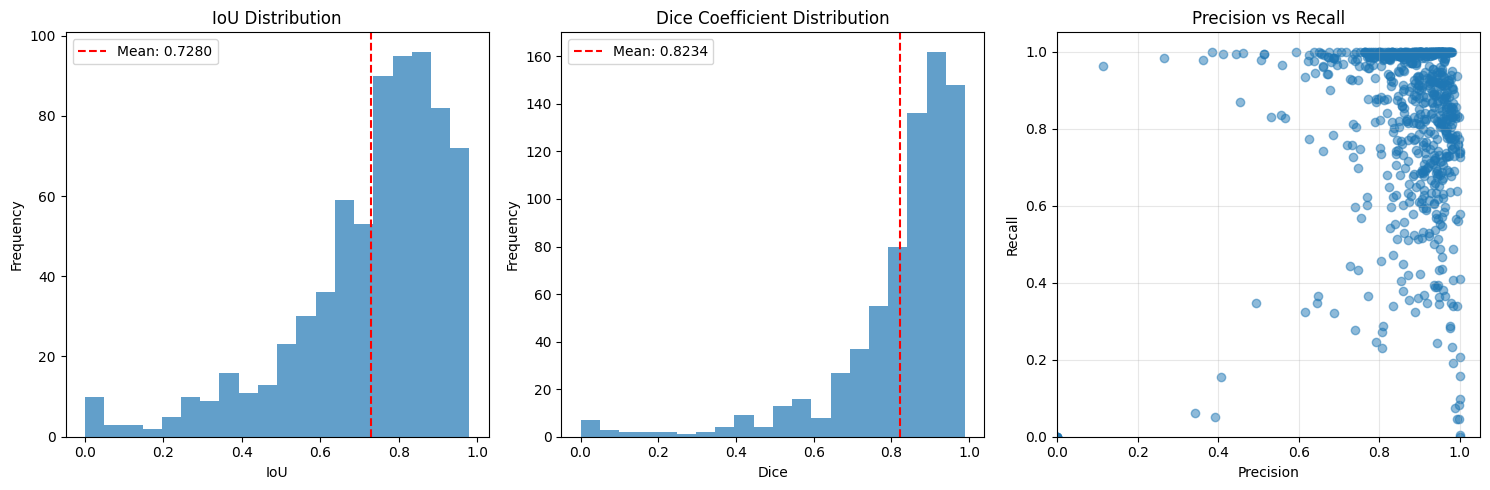

❌ Target IoU > 0.75 not achieved (Actual: 0.7280)


In [14]:
# Expanded evaluation metrics for segmentation
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

def evaluate_segmentation_metrics(model, dataloader, device, threshold=0.5):
    """
    Evaluate model performance with multiple metrics:
    - IoU (Intersection over Union)
    - Dice Coefficient (F1 Score)
    - Pixel Accuracy
    - Precision
    - Recall
    """
    model.eval()
    metrics = {
        'iou': [],
        'dice': [],
        'accuracy': [],
        'precision': [],
        'recall': []
    }
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating Metrics"):
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            batch_size = outputs.size(0)
            
            # Process each image in batch
            for i in range(batch_size):
                pred = outputs[i].squeeze().cpu().numpy()
                target = masks[i].squeeze().cpu().numpy()
                
                # Convert to binary
                pred_binary = (pred > threshold).astype(np.uint8)
                target_binary = (target > threshold).astype(np.uint8)
                
                # Flatten for metric calculation
                pred_flat = pred_binary.flatten()
                target_flat = target_binary.flatten()
                
                # Calculate IoU
                intersection = np.logical_and(pred_binary, target_binary).sum()
                union = np.logical_or(pred_binary, target_binary).sum()
                iou = intersection / union if union > 0 else 0
                metrics['iou'].append(iou)
                
                # Calculate Dice coefficient (F1 score)
                dice = 2 * intersection / (pred_binary.sum() + target_binary.sum()) if (pred_binary.sum() + target_binary.sum()) > 0 else 0
                metrics['dice'].append(dice)
                
                # Pixel accuracy
                accuracy = accuracy_score(target_flat, pred_flat)
                metrics['accuracy'].append(accuracy)
                
                # Precision and recall
                precision = precision_score(target_flat, pred_flat, zero_division=0)
                recall = recall_score(target_flat, pred_flat, zero_division=0)
                metrics['precision'].append(precision)
                metrics['recall'].append(recall)
    
    # Calculate mean metrics
    mean_metrics = {k: np.mean(v) for k, v in metrics.items()}
    std_metrics = {k: np.std(v) for k, v in metrics.items()}
    
    # Create DataFrame for nice display
    metrics_df = pd.DataFrame({
        'Metric': list(mean_metrics.keys()),
        'Mean': list(mean_metrics.values()),
        'Std Dev': list(std_metrics.values())
    })
    
    return metrics_df, metrics

# Evaluate model on validation set
metrics_df, detailed_metrics = evaluate_segmentation_metrics(model, val_loader, device)

# Display metrics
print("Model Performance Metrics:")
print(metrics_df.to_string(index=False, formatters={'Mean': '{:.4f}'.format, 'Std Dev': '{:.4f}'.format}))

# Plot metrics distribution
plt.figure(figsize=(15, 5))

# IoU distribution
plt.subplot(1, 3, 1)
plt.hist(detailed_metrics['iou'], bins=20, alpha=0.7)
plt.axvline(np.mean(detailed_metrics['iou']), color='r', linestyle='--', label=f"Mean: {np.mean(detailed_metrics['iou']):.4f}")
plt.title('IoU Distribution')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.legend()

# Dice distribution
plt.subplot(1, 3, 2)
plt.hist(detailed_metrics['dice'], bins=20, alpha=0.7)
plt.axvline(np.mean(detailed_metrics['dice']), color='r', linestyle='--', label=f"Mean: {np.mean(detailed_metrics['dice']):.4f}")
plt.title('Dice Coefficient Distribution')
plt.xlabel('Dice')
plt.ylabel('Frequency')
plt.legend()

# Precision-Recall plot
plt.subplot(1, 3, 3)
plt.scatter(detailed_metrics['precision'], detailed_metrics['recall'], alpha=0.5)
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.title('Precision vs Recall')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check if we achieved target IoU > 0.75
mean_iou = np.mean(detailed_metrics['iou'])
if mean_iou > 0.75:
    print(f"✅ Success! Achieved target IoU > 0.75 (Actual: {mean_iou:.4f})")
else:
    print(f"❌ Target IoU > 0.75 not achieved (Actual: {mean_iou:.4f})")